# Predicting Outlier Engery Consumption in On-campus Housing using building energy and weather data


* Christopher Cheng (1.5 hours): Resarched model implementation process, summarized and provided description of training and cross validation process of group model. 

* Monique Cosiquien (2.5 hours): Researched and identified prediction model from class resources (ie lecture, textbook, and past projects).

* Rio Hayakawa (2 hours): Implemented prediction model based on the data Rachel set up and Monique and Chris's research. Generated results and noted recommendations for next steps.

* Rachel Ng (2.5 hours): Researched, found and imported different data source. Set up skeleton for project including github repo. Responsible for importing, merging and describing the first dataframe.


In [1]:
# Imports
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Building the Dataframe (4 points)

### Dataset #1: Foothill building 4 data
This dataset contains the response variable and energy demand related features. We chose columns that were not `Volts` or `kVAh` or `Amps` or `kVA` as their units since we were concerned about kilowatt as our units. 

In [2]:
# Import Foothill 4 CSV file
foothill_4 = pd.read_csv('housing_data/Copy of Foothill Building 4 Electric.csv')

### Dataset #2: Weather data
We got the data from the University of [Utah's Meso West lab](https://mesowest.utah.edu/cgi-bin/droman/meso_base_dyn.cgi?stn=LBNL1).
The data could only be extracted for a single year at a time, therefore we had to merge 5 different datasets to account for the 5 years of data found in the foothill dataset.

We were concerned about pressure, air temperature, relative humidity, wind sped, precipitation and solar radiation as our feature variables for the weather dataset.

In [3]:
# Import weather data from relevant timeframe
import os
directory = 'weather_data'
weather_df = pd.DataFrame()

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        print(f)
        data = pd.read_csv(f, skiprows=6)
        weather_df = pd.concat([weather_df, data])

weather_data/LBNL1 (1).csv
weather_data/LBNL1 (2).csv
weather_data/LBNL1 (3).csv


/Users/riohayakawa/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


weather_data/LBNL1.csv
weather_data/LBNL1 (4).csv


/Users/riohayakawa/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Select the response variable and the features chosen in both the foothill df and the weather df
response = ['kW demand (kW)']
foothil_features = ['V1 THD (%)', 'PF sign total', 'kWh del (kWh)', 'I3 THD (%)', 'kW total (kW)', 'I1 THD (%)', 'V2 THD (%)', 'V3 THD (%)', 'I2 THD (%)', 'time (US/Pacific)', 'Frequency (Hz)']
weather_features = ['pressure_set_1', 'air_temp_set_1', 'relative_humidity_set_1', 'wind_speed_set_1', 'precip_accum_fifteen_minute_set_1', 'solar_radiation_set_1', 'Date_Time']



In [5]:
# Since we need to merge the data based on the time stamp, we need to convert the time column to be consisent across the 2 df's
foothill_clean = foothill_4[foothil_features + response]
foothill_clean['time (US/Pacific)'] = pd.to_datetime(foothill_clean['time (US/Pacific)'])
foothill_clean['time (US/Pacific)'] = foothill_clean['time (US/Pacific)'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')

weather_clean = weather_df[weather_features]
weather_clean['Date_Time'] = pd.to_datetime(weather_clean['Date_Time'])
weather_clean['Date_Time'] = weather_clean['Date_Time'].dt.tz_convert('US/Pacific')

<ipython-input-5-3555b21a5977>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foothill_clean['time (US/Pacific)'] = pd.to_datetime(foothill_clean['time (US/Pacific)'])
<ipython-input-5-3555b21a5977>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  foothill_clean['time (US/Pacific)'] = foothill_clean['time (US/Pacific)'].dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
<ipython-input-5-3555b21a5977>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [6]:
foothill_clean

V1 THD (%)  PF sign total  kWh del (kWh)  I3 THD (%)  kW total (kW)  \
0              1.2         -92.67      4423527.0         6.5          112.0   
1              1.1         -95.17      4423564.0         5.7          146.0   
2              0.9         -93.74      4423595.0         6.6          112.0   
3              0.7         -94.21      4423624.0         6.7          111.0   
4              1.0         -94.54      4423654.0         6.0          130.0   
...            ...            ...            ...         ...            ...   
175690         0.9         -92.60      8302369.0         7.5           92.0   
175691         0.8         -97.21      8302397.0         4.1          172.0   
175692         1.0         -95.02      8302432.0         4.9          134.0   
175693         1.5         -96.00      8302462.0         5.0          135.0   
175694         1.2         -97.43      8302495.0         4.1          172.0   

        I1 THD (%)  V2 THD (%)  V3 THD (%)  I2 THD (%)  \
0              6.7         1.2         0.9         7.8   
1              5.4         0.9         1.3         6.2   
2              6.6         1.4         0.8         7.9   
3              6.6         1.0         1.2         8.2   
4              6.7         0.6         1.2         6.4   
...            ...         ...         ...         ...   
175690         6.4         1.0         1.0         6.5   
175691         3.7         0.7         1.3         3.7   
175692         4.2         1.0         1.1         4.8   
175693         4.5         0.9         1.4         5.3   
175694         3.7         0.9         0.7         3.8   

               time (US/Pacific)  Frequency (Hz)  kW demand (kW)  
0      2017-09-09 02:00:00-07:00           60.01           149.0  
1      2017-09-09 02:15:00-07:00           59.99           108.0  
2      2017-09-09 02:30:00-07:00           59.99           152.0  
3      2017-09-09 02:45:00-07:00           59.95           121.0  
4      2017-09-09 03:00:00-07:00           60.01           115.0  
...                          ...             ...             ...  
175690 2022-09-09 01:00:00-07:00           59.99           101.0  
175691 2022-09-09 01:15:00-07:00           59.99            98.0  
175692 2022-09-09 01:30:00-07:00           59.96           119.0  
175693 2022-09-09 01:45:00-07:00           59.97           135.0  
175694 2022-09-09 02:00:00-07:00           59.99           124.0  

[175695 rows x 12 columns]

In [7]:
merged_df = weather_clean.merge(foothill_clean, right_on='time (US/Pacific)', left_on='Date_Time')
merged_df.dropna(inplace=True)

In [8]:
# Understanding the response variable
merged_df['kW demand (kW)'].describe()

count    173036.000000
mean         88.131325
std          29.532303
min           0.000000
25%          66.000000
50%          76.000000
75%         108.000000
max         206.000000
Name: kW demand (kW), dtype: float64

Text(0.5, 1.0, 'Distribution of Response variable kW demand (kW)')

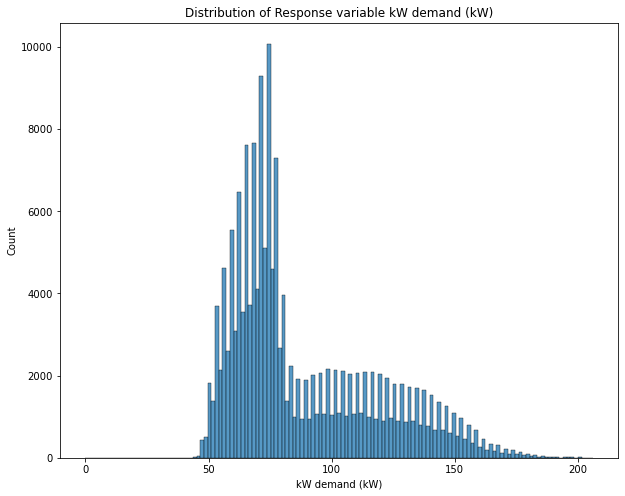

In [9]:
plt.figure(figsize=(10,8))
sns.histplot(data=merged_df, x="kW demand (kW)")
plt.title('Distribution of Response variable kW demand (kW)')

In [10]:
merged_df.dtypes

pressure_set_1                                           object
air_temp_set_1                                           object
relative_humidity_set_1                                  object
wind_speed_set_1                                         object
precip_accum_fifteen_minute_set_1                        object
solar_radiation_set_1                                    object
Date_Time                            datetime64[ns, US/Pacific]
V1 THD (%)                                              float64
PF sign total                                           float64
kWh del (kWh)                                           float64
I3 THD (%)                                              float64
kW total (kW)                                           float64
I1 THD (%)                                              float64
V2 THD (%)                                              float64
V3 THD (%)                                              float64
I2 THD (%)                              

In [11]:
merged_df = merged_df.astype({'pressure_set_1':'float','air_temp_set_1':'float', 'relative_humidity_set_1':'float', 'wind_speed_set_1':'float', 'precip_accum_fifteen_minute_set_1':'float', 'solar_radiation_set_1':'float'})

In [12]:
merged_df.describe(datetime_is_numeric=True)

pressure_set_1  air_temp_set_1  relative_humidity_set_1  \
count   173036.000000   173036.000000            173036.000000   
mean        29.078252       57.295672                66.067990   
std          0.135067        9.080743                21.889774   
min         28.440000       34.340000                 5.490000   
25%         28.990000       51.050000                50.880000   
50%         29.070000       55.700000                70.010000   
75%         29.160000       62.230000                85.100000   
max         29.630000      108.200000                96.380000   

       wind_speed_set_1  precip_accum_fifteen_minute_set_1  \
count     173036.000000                      173036.000000   
mean           4.672016                           0.000648   
std            3.035010                           0.006708   
min            0.000000                           0.000000   
25%            2.550000                           0.000000   
50%            4.180000                           0.000000   
75%            6.170000                           0.000000   
max           31.650000                           1.250000   

       solar_radiation_set_1     V1 THD (%)  PF sign total  kWh del (kWh)  \
count          173036.000000  173036.000000  173036.000000   1.730360e+05   
mean              194.883918       1.510985     -91.240855   6.443862e+06   
std               281.453331       0.636814       3.125395   1.086176e+06   
min                 0.000000       0.000000     -98.570000   4.425883e+06   
25%                 0.010000       1.000000     -93.840000   5.541149e+06   
50%                 5.000000       1.600000     -90.970000   6.534485e+06   
75%               355.200000       2.000000     -89.220000   7.354724e+06   
max              1101.000000       4.500000     -67.440000   8.302495e+06   

          I3 THD (%)  kW total (kW)     I1 THD (%)    V2 THD (%)  \
count  173036.000000  173036.000000  173036.000000  173036.00000   
mean        6.606905      88.112976       6.810646       1.61327   
std         2.212741      30.972786       2.176804       0.61297   
min         0.000000      40.000000       0.000000       0.00000   
25%         4.800000      66.000000       5.000000       1.10000   
50%         6.400000      76.000000       6.800000       1.70000   
75%         8.400000     106.000000       8.500000       2.10000   
max        13.700000     254.000000      15.700000       4.70000   

          V3 THD (%)     I2 THD (%)  Frequency (Hz)  kW demand (kW)  
count  173036.000000  173036.000000   173036.000000   173036.000000  
mean        1.636181       6.823187       59.983914       88.131325  
std         0.585061       2.042928        0.017604       29.532303  
min         0.000000       0.000000       59.860000        0.000000  
25%         1.200000       5.100000       59.970000       66.000000  
50%         1.700000       6.800000       59.980000       76.000000  
75%         2.100000       8.500000       60.000000      108.000000  
max         4.800000      22.900000       60.100000      206.000000

From this distribution plot, we can see how the kW demand (kW) is spread. For example, the mode appears to be around 80kW. In the context of this project, this could mean that values that differ from this mode has the potential to be an outlier.

#### Investigating the correlation between variables using a pairplot
The seaborn pairplot function allows us to quickly generate scatter plots between all combinations of features and responses. For example, it appears that the V1 THD, V2 THD and V3 THD feature variables have a linear relationship with one another. 
The diagonal axis of the plot also showcases the distribution of the variable. Investigating this further, we can see that kWh Del has a pretty flat distribution, with value ranging from 5-8 evenly spaced. 

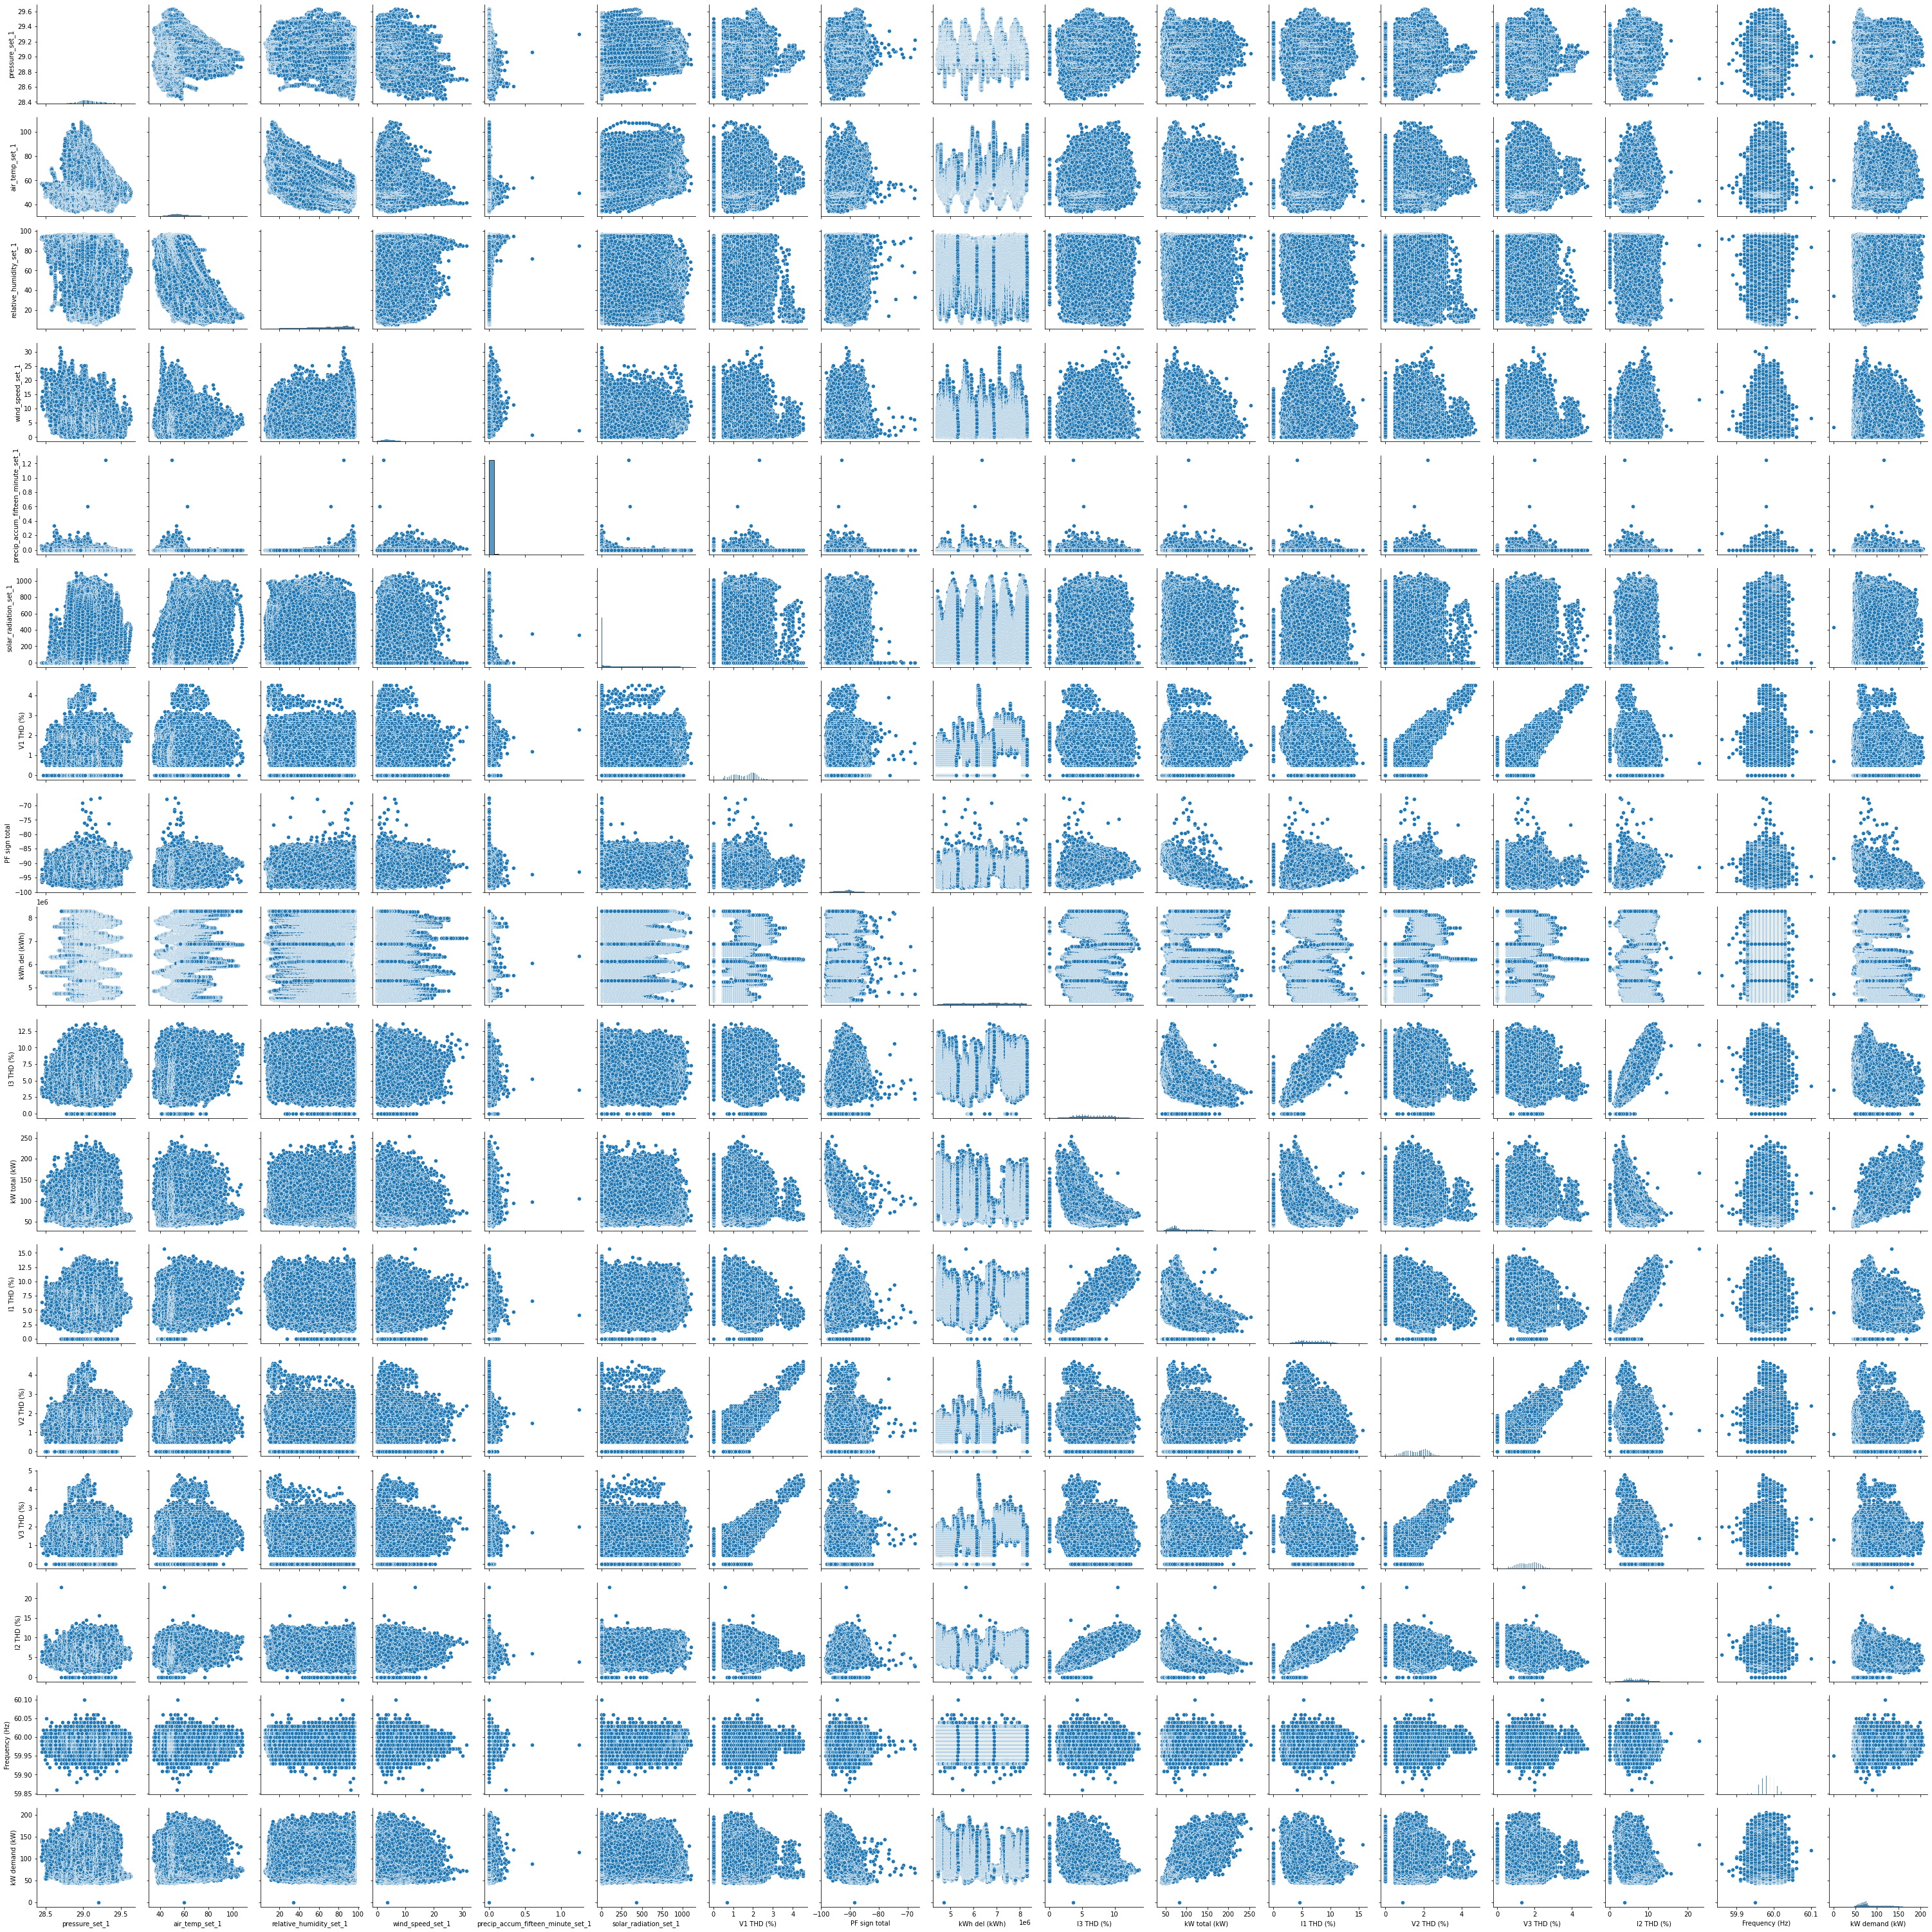

In [13]:
sns.pairplot(merged_df)

## Prediction model (4 points)

Based on the datasets and parameters, K-Nearest Neighbors (KNN) regression would be most optimal since the prediction is equivalent to the average of the K nearest point. In this context that is relevant because we wish to predict the energy demand across a local time window which will be found in the datapoints of the nearest neighbors. The reason KNN regression is the best prediction model to use is because this could potentially lead to a lower MSE (Mean Squared Errors) and high score based on a non-parametric model. Moreover, since we examine data that happened in the past it could be benefical too since it reduces variability. KNN Regression is most suited since we are working with different parameters such as time, humidity, wind speed, air temperature, etc. When working with different parameters the MSE can be skewed and can be high which is why by categorizing the data and finding an average we could find a more accurate result. We will be tuning the number of neighbors in hopes to create a model with a better score. After training the model, we predict that KNN will have the lowest MSE because of the low variability based on classification compared to the parameter based approaches. It is important that we retrieve the lowest MSE and highest score because we want the data to be closest to the true response.

## Training and cross validation (4 points)

In [14]:
### import

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

#### Feature Selection

Before using our main model of K-Nearest Neighbors for our goal of predicting outliers of building energy consumption, we used decision trees for feature selection. With our data of on campus building energy consumption along with the multiple x-variable features all pertaining to the Berkeley weather, we utilized a decision tree classifier to fit our data into a decision tree model to best maximize our predicted results. Using a decision tree allows us to select which features have a higher importance value and helps in our selection of the weather variables that contribute the most to our model predictions for building energy consumption. Here we create our target variable and training datasets, which includes all but the timestamp columns and utilize the entire dataset to make the most well-informed decision. 

In [41]:
X = merged_df[['pressure_set_1', 'air_temp_set_1', 'relative_humidity_set_1',
       'wind_speed_set_1', 'precip_accum_fifteen_minute_set_1',
       'solar_radiation_set_1', 'V1 THD (%)', 'PF sign total',
       'kWh del (kWh)', 'I3 THD (%)', 'kW total (kW)', 'I1 THD (%)',
       'V2 THD (%)', 'V3 THD (%)', 'I2 THD (%)', 
       'Frequency (Hz)']]
y = merged_df['kW demand (kW)']



In [42]:
def importance_plot(tree):
    feature_importance = tree.feature_importances_
    
    #relative feature importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    
    feat_df = pd.DataFrame({'feature':X_train.columns, 'importance':feature_importance})
    feat_df = feat_df.sort_values(by='importance', ascending=True)
    
    # Bar plot 
    plt.figure(figsize=(8, 7.5))
    plt.barh(width=feat_df.importance, y=feat_df.feature)
    plt.xlabel('Relative feature importance');

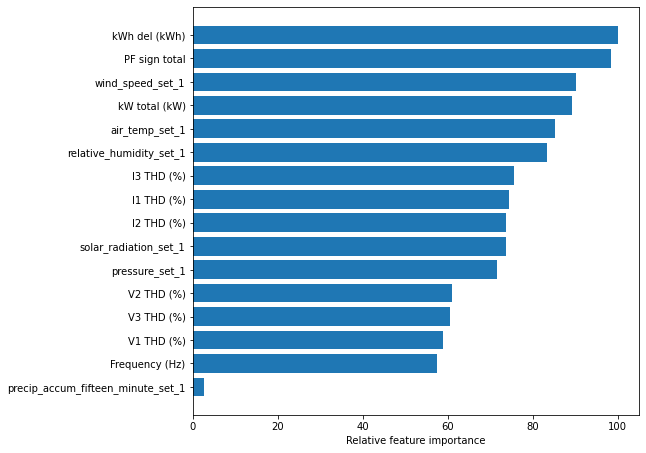

In [43]:
d = DecisionTreeClassifier(random_state=2021)
d.fit(X, y)

importance_plot(d)

From our decision tree and importance value plot, we see that the features `kWh del (kWh)`, `PF sign total`, `wind_speed_set_1`, and `kW total (kW)` have the highest importance. However, we must note that `kWh del (kWh)` is the amount of electricity delivered to the consumer and `kW total (kW)` is the total electricity, both are based on the same measurement and is in direct relation to our target variable, `kW demand (kW)`. It is debatable which are valid in the context of prediction but we decided that it is a bit unfair so we will not include it as a feature variable. `PF sign total` is also debatable since it describes the Power factor, measure of electricity usage efficiency, but deemed it was not a direct measurement of the demand. Hence, we will focus on the top four features excluding the exceptions to be applied in our model, which come to be `PF sign total`, `wind_speed_set_1`,  `air_temp_set_1`, and `relative_humditiy_set_1`.

#### Test train split and cross validation

We used K-Nearest Neighbors regression as our method of estimating for the case of predicting kW energy consumption of on campus buildings by using the sklearn function `cross_val_score` to split train and tests sets from our imported data sets and analyze, evaluate the score of our KNN model method. Using the sklearn KNN Regression model, `KNeighborsRegressor`, we predict a outcome value based off a local average from the training data and output variable from nearby local probability groupings. 
We then test the `n` value of our k-nn model across a range to tune the hyperparameter of our K-Nearest Neighbor model in order to see which value of `n` generates a better validation score.


In [44]:
X = merged_df[['PF sign total', 'air_temp_set_1', 'relative_humidity_set_1','wind_speed_set_1']]
y = merged_df['kW demand (kW)']


print(X)
print(y)

X, X_test, y, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

        PF sign total  air_temp_set_1  relative_humidity_set_1  \
0              -90.60           56.76                    92.90   
1              -90.60           56.76                    92.90   
2              -91.52           56.76                    92.90   
3              -90.92           56.73                    92.90   
5              -91.04           56.67                    93.00   
...               ...             ...                      ...   
174782         -89.41           62.80                    64.94   
174783         -90.21           62.06                    65.64   
174784         -91.77           61.68                    66.37   
174785         -89.90           61.61                    65.22   
174786         -90.11           63.73                    51.56   

        wind_speed_set_1  
0                   0.68  
1                   0.68  
2                   1.39  
3                   2.51  
5                   2.81  
...                  ...  
174782            

In [36]:
def cross_validate(model, X, y, k=5):
    kf = KFold(n_splits=k, random_state=None)
    result = cross_val_score(model, X, y, cv = kf)
    return result.mean()

In [37]:
### Hyperparameter tuning

for n in range(2, 52, 2):

    knn_model = KNeighborsRegressor(n_neighbors=n)
    score = cross_validate(knn_model, X, y)
    print(f'Avg Score for {n} neighbors: {score}')


Avg Score for 2 neighbors: 0.6256137400342862
Avg Score for 4 neighbors: 0.6846444560863159
Avg Score for 6 neighbors: 0.7031345041924139
Avg Score for 8 neighbors: 0.7120278247722143
Avg Score for 10 neighbors: 0.7170000895072793
Avg Score for 12 neighbors: 0.7197780536222862
Avg Score for 14 neighbors: 0.7217750350857649
Avg Score for 16 neighbors: 0.7227871494135913
Avg Score for 18 neighbors: 0.7237810476071578
Avg Score for 20 neighbors: 0.7242291706349364
Avg Score for 22 neighbors: 0.7247336601268222
Avg Score for 24 neighbors: 0.7249122620983277
Avg Score for 26 neighbors: 0.7251366663613357
Avg Score for 28 neighbors: 0.7252285843425239
Avg Score for 30 neighbors: 0.7252873142166764
Avg Score for 32 neighbors: 0.7250990090898564
Avg Score for 34 neighbors: 0.724975783229647
Avg Score for 36 neighbors: 0.7247636296047079
Avg Score for 38 neighbors: 0.7247435739852482
Avg Score for 40 neighbors: 0.7246173427384786
Avg Score for 42 neighbors: 0.7243678904760321
Avg Score for 44 n

## Evaluation and next steps (4 points)

From above, we can see that as we increase the number of neighbors, the score steadily increases until we hit the highest mean score of approximately 0.72528 at n = 30 neighbors, and plateaus. Using this value, we create a new instance of the model with n = 30 and fit the model accordingly to our training data.

In [38]:
knn_model = KNeighborsRegressor(n_neighbors=30)
knn_model.fit(X, y)

pred = knn_model.predict(X_test)

mse = mean_squared_error(pred, y_test)
score = knn_model.score(X_test, y_test)

print(f'MSE: {mse}')
print(f'Score: {score}')

MSE: 237.70621728041175
Score: 0.7282791161343243


After generating a prediction, we learn that the prediction of the test data is consistent, if not even better than the score of the training data, at approximately 0.72828. 

However, in terms of a valid model, the current score is not acceptable and have much to build upon:
#### Next Steps:
1. Create a more complex model. Currently the model is making a prediction based on all past data, which generates way too general of a result to be useful. Instead we wish to predict based on a specific time window leading up to the day we wish to predict. We can do this by using the ForecasterAutoreg class in Skforecast to specify "lags" to train the data over x amount of days in the past and make local predictions in time. The issue with this is that there are patterns throughout the context in time that energy consumption follows such as weekly, monthly, and yearly patterns that is not linear. This window size variable will be one of the important hyperparameters to tune when implementing this.
2. Expand the dataset to encompass all on campus housing buildings to create a more generalized model.
3. Incorporate alternative external data since we learned that general weather data has a weak correlation with energy consumption.